In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from astral import Astral, AstralGeocoder, Location

from sklearn.metrics import accuracy_score
import statsmodels.api as sm

from calculations import *
from plotting import *

from patsy import dmatrix

import datetime

plt.style.use('ggplot')
%matplotlib inline

# Open Policing Project Tutorial

## Setup
***

We typically import all the relevant libraries and functions right at the start of our .py file or .ipynb notebook. All the required libraries should be available to you after you run the `setup.py` file available on the github repository.

**Note**: Since we are in a .ipynb notebook, and we want to display our matplotlib graphs next to our code, we used a 'magic function' `%matplotlib inline` (prefixed with `%`), to set the backend of matplotlib to the 'inline' backend. There are tons of 'magic functions' in IPython and you can find out more [here](https://ipython.readthedocs.io/en/stable/interactive/tutorial.html#magics-explained)!

## Covering the Basics
***

In [2]:
# http://data.cityofsacramento.org/datasets/a8cb4c137c824e939dca586c6dc77da9_0/data
sacramento_stops = pd.read_csv('data/sacramento_stops.csv')
sacramento_stops.head()

,Idx,CitationNumber,EntryDate,StopType,StopDTS,StopCause,ViolationNumber,SpecialCondition,Race,Gender,...,ResultCitation,ResultArrest,ResultReport,ResultAdvised,ResultFC,CadCallNumber,DetentionDuration,OfficerAbra,LimitedLanguage,FID
0,430490,NaN,2017-03-22T02:28:48.000Z,VEHICLE,2017-03-22T02:09:00.000Z,REGISTRATION OR REQUIRED EQUIPMENT VIOLATION,4000A,NOT APPLICABLE,ASIAN/PACIFIC ISLANDER,M,...,False,False,False,True,False,17-080525,10,4077,False,4001
1,430491,NaN,2017-03-22T02:47:35.000Z,VEHICLE,2017-03-22T02:10:00.000Z,REGISTRATION OR REQUIRED EQUIPMENT VIOLATION,4000(A) VC,NOT APPLICABLE,AFRICAN AMERICAN,F,...,False,False,False,True,False,17-080526,15,4183,False,4002
2,430492,NaN,2017-03-22T02:56:58.000Z,VEHICLE,2017-03-22T02:43:00.000Z,REGISTRATION OR REQUIRED EQUIPMENT VIOLATION,5200A,NOT APPLICABLE,AFRICAN AMERICAN,F,...,False,False,False,True,False,17-080553,10,4077,False,4003
3,430493,NaN,2017-03-22T03:00:28.000Z,VEHICLE,2017-03-15T01:38:00.000Z,REGISTRATION OR REQUIRED EQUIPMENT VIOLATION,4000A VC,NOT APPLICABLE,AFRICAN AMERICAN,F,...,False,False,False,True,False,17-073156,15,3477,False,4004
4,430494,NaN,2017-03-22T03:09:24.000Z,VEHICLE,2017-03-15T01:22:00.000Z,REGISTRATION OR REQUIRED EQUIPMENT VIOLATION,4000A VC,NOT APPLICABLE,HISPANIC,M,...,False,False,False,False,False,17-073141,5,3477,False,4005


A `pandas` dataframe is basically what you would expect of a spreadsheet. Data is arranged in a tabular format, with each column representing a feature, and each row being a particular observation. It is often particularly important to understand the granularity of the data you are given, where granularity describes what each observation represents. Here, each observation is a police stop. The columns thus represent the details of a police stop, i.e. reason behind the stop, the race of the person stopped. In order to better understand the data, we get some quick summaries.

In [3]:
sacramento_stops.shape, sacramento_stops.columns.values

((59235, 36),
 array(['Idx', 'CitationNumber', 'EntryDate', 'StopType', 'StopDTS',
        'StopCause', 'ViolationNumber', 'SpecialCondition', 'Race',
        'Gender', 'BirthYear', 'ExitVehicle', 'PassengerCount',
        'SearchDriver', 'SearchPassenger', 'SearchVehicle', 'Authority',
        'ConsentRequested', 'ConsentGranted', 'FSWeapons', 'FSDrugs',
        'FSCash', 'FSVehicle', 'FSAlcohol', 'FSOtherProperty', 'FSNothing',
        'ResultCitation', 'ResultArrest', 'ResultReport', 'ResultAdvised',
        'ResultFC', 'CadCallNumber', 'DetentionDuration', 'OfficerAbra',
        'LimitedLanguage', 'FID'], dtype=object))

In [4]:
sacramento_stops.describe() 

,Idx,BirthYear,PassengerCount,DetentionDuration,OfficerAbra,FID
count,59235.000000,59235.000000,59235.000000,59235.000000,59235.000000,59235.000000
mean,459747.654647,1982.200827,0.577648,12.090014,3806.103604,29618.000000
std,20073.005009,13.623040,1.974042,14.102620,899.490514,17099.815935
min,426190.000000,1900.000000,0.000000,0.000000,5.000000,1.000000
25%,442437.500000,1974.000000,0.000000,8.000000,3602.000000,14809.500000
50%,459246.000000,1986.000000,0.000000,10.000000,4094.000000,29618.000000
75%,477051.500000,1993.000000,1.000000,15.000000,4345.000000,44426.500000
max,495864.000000,2019.000000,425.000000,543.000000,5453.000000,59235.000000


We started by looking at the shape of our dataframe. Our dataframe has 59235 rows, and 36 columsn. This means that there 59235 stops in our dataset, and there are 36 possible features, which we also listed out. The `.describe()` method is often a quick tool to (mainly) get the key statistics of the quantitative features in our data. This lets us find the average, standard deviation, range, etc. of the quantitative features. 

What is the date range that our data covers though? It is important to know the dates of analysis so that we can make better comparison with other states/muncipals. We note that the column for dates `StopDTS`, is not encoded in datetime format yet. There are other ways of converting strings to datetime format, but `pandas` has a very convenient `to_datetime()` function that does the job for us. With a datetime object, it is then extremely simple to extract various time information from our data, i.e. year, month, day, time. Here, we just extracted/separated the date and time objects.

**Note**: When we deal with time data, it is important to note the appropriate timezone. This should usually be documented in a data dictionary, or a documentation of the dataset. Here, we note that times are in UTC.

In [5]:
# As according to the documentation of the dataset, times are in UTC. Keep that in mind when during veil of darkness
sacramento_stops['date'] = pd.to_datetime(sacramento_stops['StopDTS']).apply(lambda date: date.date)
sacramento_stops['time'] = pd.to_datetime(sacramento_stops['StopDTS']).apply(lambda date: date.time)

In [6]:
sacramento_stops['date'].min(), sacramento_stops['date'].max()

(datetime.date(2017, 2, 1), datetime.date(2019, 1, 1))

It seems like the data is from February 1st 2017 to January 1st 2019. There are not alot of observations in 2019 given that it is only 1 day. As such, we decided to exclude the observations on January 1st 2019 in our analysi. This is a relatively straightforward process using standard `pandas` filtering mechanism shown below.

In [7]:
start_date = datetime.date(2017,2,1)
stop_date = datetime.date(2019,1,1)
sacramento_stops = sacramento_stops[(sacramento_stops['date'] >= start_date) & (sacramento_stops['date'] < stop_date)]

For the purposes of our analysis, we want to filter out just the observations for vehicular stops. For this dataset, there are only vehicular stops data. However, you may find datasets with pedestrian stops data as well. It might then be interesting to do whole new analysis on pedestrian stops data.

In [8]:
sacramento_stops.StopType.unique()

array(['VEHICLE'], dtype=object)

In most of the datasets that you will find, some form of pre-processing is necessary before you can conduct any analysis on it. It can range from filtering dates to dealing with missing data. Importantly, you should have some form of understanding of the type of analysis intended for your data pre-processing. Let us start by identifying whether there is missing data or corrupted fields. It is easy to identify missing data in general with the `.isna()` function which returns a boolean if the row has a missing field. 

**Note**: If you wish to replace missing data, there are several ways of approaching the problem. You may just replace it with a 0, the mean of the field, etc. or you may just include an indicator column. There are even more principled ways of imputing missing values! However, there is no hard and fast rule, just remember to justify why you did it, and how do you think it will bias your results.

In [9]:
# list missing data
for col in sacramento_stops.columns:
    missno = np.sum(sacramento_stops[col].isna())
    if missno > 0:
        print('{} has {} missing rows'.format(col, missno))

CitationNumber has 39160 missing rows
ViolationNumber has 95 missing rows
ExitVehicle has 701 missing rows
ConsentRequested has 28750 missing rows
ConsentGranted has 55302 missing rows


Thankfully, it seems like we will not be using the fields with missing values for our analysis (for now). 

Dealing with corrupted fields is arguably even trickier. A corrupted field is basically a field that you may have reason to believe has been wrongly entered. If there is a well-documented data dictionary with clear constraints applied to each field, this might not be a big issue. However, it often takes plenty of time at staring at your data before you can identify corrupted fields. And there may not even be any issues with your data! 

For this particular dataset, we found that there were observations in which a search was not conducted, but there were contrabands found. This seems slightly contradictory. Although it is entirely possible that a person gives up their contraband without being searched, it is not particularly common and it would make our analysis trickier. We decided to remove those observations. 

**Note**: For the ease of analysis, we also grouped `SearchDriver`, `SearchPassenger`, and `SearchVehicle` together into one variable representing whether any search was conducted. We note that the race variable is specfically for the driver. As such, we only considered instances when at least one of the driver or the vehicle were searched as an indicator of whether any search was conducted. Intuitively, if only the passenger was searched, it does not make sense to correlate the race of the driver with the stop.  

Similarly, we also grouped `FSAlcohol`, `FSCash`, `FSDrugs`, `FSOtherProperty`, `FSWeapons`, and `FSVehicle` together into one variable representing whether any contraband item was found. We note that not all datasets are so detailed about the type of contraband item that was confiscated. As such, we might do a subsequent analysis making use of the different types of contrabands.

In [10]:
sacramento_stops['search_conducted'] = ((sacramento_stops['SearchDriver']) | (sacramento_stops['SearchVehicle']))
sacramento_stops['search_conducted'].sum()

7874

In [11]:
sacramento_stops['contraband_found'] = ((sacramento_stops['FSAlcohol']) | (sacramento_stops['FSCash']) |
                                       (sacramento_stops['FSDrugs']) | (sacramento_stops['FSOtherProperty']) |
                                       (sacramento_stops['FSWeapons']) | (sacramento_stops['FSVehicle']))
sacramento_stops['contraband_found'].sum()

1558

In [12]:
# Search not conducted, but contraband found. only 46 observations like these. Remove
sacramento_stops = sacramento_stops[~((~sacramento_stops['search_conducted']) & (sacramento_stops['contraband_found']))]

Now that we have cleaned our data, let us get a quick sense of the count and proportion of stops by race and/or year and month in Sacremento. We see that there are some of race categories that can be grouped together for the purposes of our analysis.

In [13]:
sacramento_stops['Race'].unique()

array(['ASIAN/PACIFIC ISLANDER', 'AFRICAN AMERICAN', 'HISPANIC', 'WHITE',
       'OTHER/NOT APPARENT', 'ASIAN OTHER', 'UNKNOWN', 'NATIVE AMERICAN',
       'MIXED RACE', 'CHINESE', 'AM. IND./AL. NATIVE', 'EAST INDIAN',
       'ASIAN INDIAN', 'MIEN', 'HAWAIIAN', 'MIDDLE EASTERN',
       'CUBAN/CARRIBEAN', 'PACIFIC ISLANDER', 'HMONG', 'FILIPINO',
       'GUAMANIAN', 'VIETNAMESE', 'SAMOAN', 'ORIENTAL/ASIAN', 'CAMBODIAN',
       'JAPANESE'], dtype=object)

In [14]:
# Convert to standardized names
sacramento_stops['subject_race'] = sacramento_stops['Race'].str.lower()
sacramento_stops['subject_race'] = sacramento_stops['subject_race'].replace({
                                    'other/not apparent': 'other/unknown',
                                    'asian other': 'asian/pacific islander',
                                    'chinese': 'asian/pacific islander',
                                    'east indian': 'asian/pacific islander',
                                    'pacific islander': 'asian/pacific islander',
                                    'vietnamese': 'asian/pacific islander',
                                    'oriental/asian': 'asian/pacific islander',
                                    'cambodian': 'asian/pacific islander',
                                    'japanese': 'asian/pacific islander',
                                    'asian indian': 'asian/pacific islander',
                                    'hmong': 'asian/pacific islander',
                                    'filipino': 'asian/pacific islander',
                                    'mien': 'asian/pacific islander',
                                    'hawaiian': 'asian/pacific islander',
                                    'samoan': 'asian/pacific islander',
                                    'guamanian': 'asian/pacific islander',
                                    'mixed race': 'other/unknown',
                                    'am. ind./al. native': 'other/unknown',
                                    'middle eastern': 'other/unknown',
                                    'cuban/carribean': 'hispanic',
                                    'unknown': 'other/unknown',
                                    'native american': 'other/unknown'
                    })

sacramento_stops['subject_race'].unique()

array(['asian/pacific islander', 'african american', 'hispanic', 'white',
       'other/unknown'], dtype=object)

In order to group the data by categories, we have to use a `.groupby()` function. The basic setup is `df.groupby([COLUMNS TO GROUP BY]).FUNC()` where we apply an aggregation function `FUNC()` across each of the grouped categories. 

In [15]:
sacramento_stops['year'] = sacramento_stops['date'].apply(lambda date: date.year)
sacramento_stops['month'] = sacramento_stops['date'].apply(lambda date: date.month)
(sacramento_stops
 .groupby(['year', 'month'], as_index=False)['Idx']
 .agg({'count': len,
       'prop': lambda x: len(x)/len(sacramento_stops)}))

,year,month,count,prop
0,2017,2,2332,0.039414
1,2017,3,2926,0.049453
2,2017,4,2466,0.041679
3,2017,5,1619,0.027363
4,2017,6,1956,0.033059
5,2017,7,2750,0.046479
6,2017,8,2718,0.045938
7,2017,9,2480,0.041915
8,2017,10,2756,0.046580
9,2017,11,2509,0.042405


In [16]:
(sacramento_stops
 .groupby(['subject_race'], as_index=False)['Idx']
 .agg({'count': len,
       'prop': lambda x: len(x)/len(sacramento_stops)}))


,subject_race,count,prop
0,african american,20184,0.341136
1,asian/pacific islander,4263,0.072050
2,hispanic,12833,0.216895
3,other/unknown,6014,0.101644
4,white,15873,0.268275


What if we wanted to check the number of stops by race and year? We could do a `groupby` function, but it would be difficult to interpret. Instead, let us plot a graph with `seaborn`. `seaborn` allows us to make plots with an implicit groupby through the parameter `hue`. Most of the seaborn plotting functions will have the parameter, which basically groups the data by a category before plotting. This allows us to represent a 3rd dimension in our plots, through different colors. You could of course do this with the basic `matplotlib`, but it is much easier with `seaborn`.

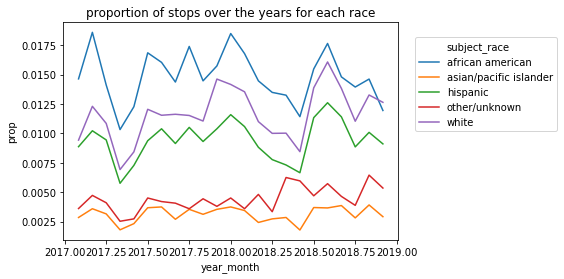

In [17]:
race_year_plot = (sacramento_stops
                  .groupby(['subject_race', 'year', 'month'], as_index=False)['Idx']
                  .agg({'count': len,
                        'prop': lambda x: len(x)/len(sacramento_stops)}))
# in order to plot year and month, we make a new column compressing the information
race_year_plot['year_month'] = race_year_plot['year'] + (race_year_plot['month']-1)/12.

ax = sns.lineplot(x='year_month', y='prop', hue='subject_race', data=race_year_plot)
ax.legend(loc = (1.05, 0.5))
ax.set_title('proportion of stops over the years for each race');

From this plot, it seems that for most of the races, the trend over the years has been pretty similar. We note that there seems to be a cyclical pattern where there seems to be a dip in traffic stops near the start of the year. This might be interesting for a different follow-up study. Importantly, we note that the proportion of stops has been largely higher for African Americans over the years, although it seems that the proportion of stops is higher for Whites in the last month of 2018. This does not necessarily mean much though, as it may simply be the case that there are more African Americans in Sacramento. Nonetheless, this is a good start for deeper analysis!

## Benchmark Test
***

### Stop rates

As we alluded to previously, in order to do a baseline comparison, we need to have the population proportions across racial demographics in Sacremento. Let us also just do the analysis for 2018. 

In [18]:
stops_2018 = sacramento_stops[sacramento_stops['date'].apply(lambda date: date.year == 2018)]

In [19]:
#https://www.census.gov/quickfacts/fact/table/sacramentocountycalifornia,ca/PST045217
sacramento_population_2018 = 1530615

#White, Black, Hispanic
sacramento_race_percentages = {"white": .448, "african american": .109 , "hispanic": .186, 
                              "asian/pacific islander": .179, 'other/unknown': 0.077}
sacramento_race_demo = pd.DataFrame(sacramento_race_percentages, index=['prop']).T.reset_index()
sacramento_race_demo.columns = ['subject_race', 'prop']
sacramento_race_demo['count'] = sacramento_race_demo['prop']*sacramento_population_2018
sacramento_race_demo

,subject_race,prop,count
0,white,0.448,685715.520
1,african american,0.109,166837.035
2,hispanic,0.186,284694.390
3,asian/pacific islander,0.179,273980.085
4,other/unknown,0.077,117857.355


Now that we have the population demographics in Sacremento, let us calculate the stop rate per capita for each race. We basically merge the dataframe with total number of stops for each demographic with the dataframe with the total number of residents in each demographic, and divide the two columns. The merge can be easily done with a `merge()` function. The exact details of a merge function requires us to go into detail about the differences between a left merge, right merge, inner merge, outer merge, etc. As such, we would not go into detail. Instead, we would encourage the reader to read the existing [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) for the `merge` function. Whenever you come across a new function, you should always read through the documentation to make sure you understand what the function does. In short, the `merge` function basically concatenates two dataframes across columns, based on a specific shared column. 

In [20]:
sacramento_stops_race = (stops_2018
                         .groupby(['subject_race'], as_index=False)['Idx']
                         .agg({'count': len}))

sacramento_stop_rates = sacramento_stops_race.merge(sacramento_race_demo, how='left', on='subject_race')
sacramento_stop_rates['stop_rate'] = sacramento_stop_rates ['count_x'] / sacramento_stop_rates ['count_y']
sacramento_stop_rates.drop(['count_x', 'count_y', 'prop'], axis=1, inplace=True)
sacramento_stop_rates

,subject_race,stop_rate
0,african american,0.062540
1,asian/pacific islander,0.008190
2,hispanic,0.024142
3,other/unknown,0.029756
4,white,0.012762


Now we can make better statements about the stop rates for each race! It seems that black drivers are stopped at a rate almost 5 times higher than white drivers!

### Search rates

Let us do the same comparison and analysis for search rates. Instead of using the total population size as a baseline (as in stop rates), it makes sense to instead use the stopped population. As such, search rate is the proportion of stopped people who were subsequently searched. 

**Note**: Some states and municpals also include frisk rates. It may be worth your time to do a similar analysis on frisk rates as well.

In [21]:
(stops_2018
 .groupby('subject_race', as_index=False)['search_conducted']
 .agg({'stop_rate': np.mean}))

,subject_race,stop_rate
0,african american,0.206345
1,asian/pacific islander,0.070856
2,hispanic,0.150153
3,other/unknown,0.075278
4,white,0.076220


Similar to stop rates, it seems that black drivers are searched almost 3 times as much as white drivers! This seems ridiculous, but let us not make any conclusions without more principled approaches to understanding these statistics. 

### Caveats about the benchmark test

The benchmark test is useful for some quick statistics, but it does not provide any evidence of discrimination. This is because we have not been comparing to the correct baseline. In particular, the stop rates need not necessarily suggest that black drivers have been disproportionately stopped. Some of you may have already noticed, but we have been calculating the rate with respect to the total population within each demographic when we should be calculating the rate with respect to the total number of individuals breaking traffic laws, or exhibiting other criminal behavior in their vehicles. Ideally, if we know that the number of black drivers stopped is disproportionate to the total number of offenders, then we would have strong evidence that there is racial discrimination. Unfortunately, there is no way to have a good measure of the total number of offenders. Using arrest rate would not be a good proxy as arrest rate could similarly be racially skewed as well. 

Search rates are perhaps a safer measure, and it is indeed as what we have observed. The ratio of stop rates for black and white drivers is considerably higher than the ratio of search rates for black and white drivers. Nonetheless, we should conduct more principled analysis of our data before we make any conclusions.

## Outcome Test
***

Following our observations in the benchmark test, it makes sense to analyze the search decision rather than the stop decision. A successful search is when the driver/vehicle is found to own contraband. We define the proportion of successful searches, by race, as the **hit rate**, or otherwise known as the contraband recovery rate. If there is a disproprotion in hit rate across different racial groups, we might have reason to believe that there is discrimination. 

In [22]:
# originally wrong, have to filter just those that were searched
(stops_2018[stops_2018['search_conducted']]
 .groupby('subject_race', as_index=False)['contraband_found']
 .agg({'hit_rate': np.mean}))

,subject_race,hit_rate
0,african american,0.177891
1,asian/pacific islander,0.226415
2,hispanic,0.230620
3,other/unknown,0.166667
4,white,0.254873


We see that hit rates are much lower for black drivers as compared to white drivers. However, this might be because the bar for stopping people (and thus searching them for contraband) is lower in certain police districts. So we should adjust for the locations to check if the disparity really reflect bias. This is indeed the approach taken by the Stanford Open Policing Project. 

However, in the case of the Sacremento dataset, we do not have the police districts data. However, we believe that controling based on the police officer might be just as, or even better, than using police district data. Police officers are assigned to specific police districts, and it is likely that they will stay within the same police district within a specific year. As such, they are reasonable proxies. Moreover, if we can check that police officers have huge disparity in hit rates across different racial groups, this might be even more compelling evidence that there is racial discrimination. 

### Adjusting for police officer

In [23]:
hit_rates = (stops_2018[stops_2018['search_conducted']]
             .groupby(['subject_race', 'OfficerAbra'], as_index=False)['contraband_found']
             .agg({'hit_rate': np.mean}))
hit_rates.head()

,subject_race,OfficerAbra,hit_rate
0,african american,10,1.00
1,african american,45,0.00
2,african american,50,0.00
3,african american,153,0.25
4,african american,263,0.00


Especially because we are grouping based on the police officer, rather than police districts, we have a huge table that is hard to interpret. Let us plot the hit rates of minority racial groups as compared to white drivers. In order to do so, we would need to reshape our hit rate dataframe such that for each police officer, we have their hit rate on whites and also their hit rates on each of the minority races. This requires some imaginative reshaping that might not be very intuitive. However, the key thing to note is that there are 2 key functions that can reshape pandas dataframe: `pivot_table` and `melt`. They are essentially opposites. The former pivots a dataframe to a wide format; the latter unpivots a dataframe to a long format. We basically want to replicate white hit rates as an additional column for every instance of a minority hit rate. Take your time to try to understand the code, and read up the documentation if you are still not clear!

In [24]:
hit_rates = (pd
             .pivot_table(hit_rates, 
                          index='OfficerAbra', 
                          columns='subject_race', 
                          values='hit_rate', 
                          fill_value=0)
             .rename({'white': 'white_hit_rate'}, axis=1).reset_index()
             .melt(id_vars=['OfficerAbra', 'white_hit_rate'], 
                   value_vars=['african american', 'asian/pacific islander', 'hispanic', 'other/unknown'],
                   value_name='minority_hit_rate')
             .sort_values('OfficerAbra')
             .reset_index(drop=True)
             .rename({'subject_race': 'minority_race'}, axis=1))
hit_rates.head()

,OfficerAbra,white_hit_rate,minority_race,minority_hit_rate
0,10,0.0,african american,1.0
1,10,0.0,hispanic,0.0
2,10,0.0,other/unknown,0.0
3,10,0.0,asian/pacific islander,0.0
4,25,0.0,hispanic,0.0


Now let us make some comparison plots!

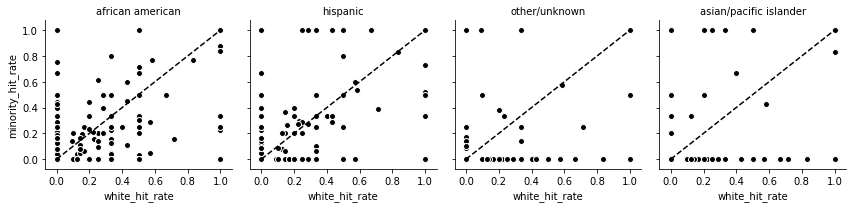

In [25]:
g = sns.FacetGrid(hit_rates, col='minority_race')
g = g.map_dataframe(plt.plot, [0,1], [0,1], 'r--', color='black')
g = (g.map(plt.scatter, 'white_hit_rate', 'minority_hit_rate', edgecolor='w', color='black')
     .set_titles("{col_name}"))


What if the datapoints which are above the 45 degree line (i.e. where minority hit rate is equal to white hit rate) have most of the population within Sacremento? That might suggest that we should give those datapoints more weight. Intuitively, each police officer has different number of total searches. As such, we should include the total number of searches for each police officer as an additional dimension. This would similarly be the case if we were using police districts as well. Let us update our dataframe as well as our plots.

In [26]:
search_counts = (stops_2018[stops_2018['search_conducted']]
                .groupby(['subject_race', 'OfficerAbra'], as_index=False)['Idx']
                .agg({'count': len})
                .pivot_table(index='OfficerAbra',
                            columns='subject_race',
                            values='count',
                            fill_value=0)
                .rename({'white': 'num_white_searches'}, axis=1).reset_index()
                .melt(id_vars=['OfficerAbra', 'num_white_searches'],
                     value_vars=['african american', 'asian/pacific islander', 'hispanic', 'other/unknown'],
                     value_name='num_minority_searches')
                .sort_values('OfficerAbra')
                .reset_index(drop=True)
                .rename({'subject_race': 'minority_race'}, axis=1))
search_counts['num_searches'] = search_counts['num_white_searches']+search_counts['num_minority_searches']
search_counts.drop(['num_white_searches', 'num_minority_searches'], axis=1 , inplace=True)

hit_rates_search = hit_rates.merge(search_counts, how='left', on=['OfficerAbra', 'minority_race'])
hit_rates_search.head()

,OfficerAbra,white_hit_rate,minority_race,minority_hit_rate,num_searches
0,10,0.0,african american,1.0,1
1,10,0.0,hispanic,0.0,0
2,10,0.0,other/unknown,0.0,0
3,10,0.0,asian/pacific islander,0.0,0
4,25,0.0,hispanic,0.0,1


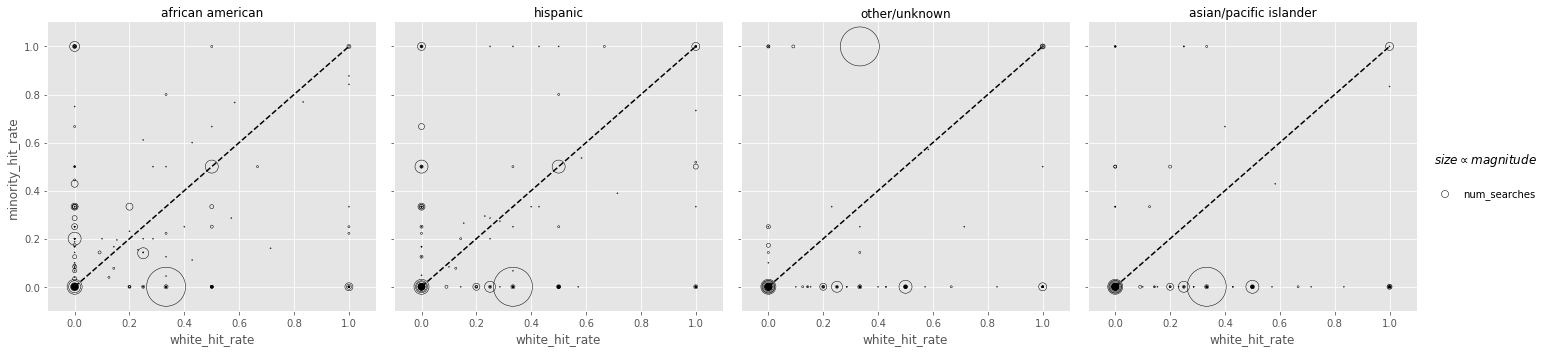

In [47]:
# sizes of points seem wrong....

# create bins
bins = np.linspace(hit_rates_search['num_searches'].min(), hit_rates_search['num_searches'].max(), 5)
# hit_rates_search['bins'] = np.digitize(hit_rates_search['num_searches'], bins)
# somehow facet scatterplot size removes outliers? 
#bins_dat = np.array([250 if (i==1) or (i==4) else i for i in bins_dat])
g = sns.FacetGrid(hit_rates_search, col='minority_race', height=5)
g = g.map_dataframe(plt.plot, [0,1], [0,1], 'r--', color='black')
g = (g.map(plt.scatter, 
           'white_hit_rate', 
           'minority_hit_rate',
           s=(hit_rates_search['num_searches']*1)**2,
           edgecolors='black', 
           facecolors='none')
     .set_titles("{col_name}")
    .set(xlim=(-0.1,1.1), ylim=(-0.1,1.1)))

# make a legend
#for i,b in enumerate(bins,1):
#    plt.scatter([], [], s=np.array([(i*5)**2]), edgecolors='black', facecolors='none', label=str(int(b)))

plt.scatter([], [], s=50, edgecolors='black', facecolors='none', label='num_searches')
h, l = plt.gca().get_legend_handles_labels()
legend = {labels: handles for handles, labels in zip(h,l)}
g.add_legend(legend, title=r'$size \propto magnitude$',labelspacing=2);


Due to the huge disparity between the number of searches of each police officer, we decided to not bin the number of searches like in the Stanford Open Policy Project (which was with respect to police districts rather than police officers). This would allow us to better identify the outliers in our dataset. 

It would seem that there is a good spread of hit races across all demographics for most police officers. Interestingly, there seems to be a particular officer who largely hits on white drivers. Nonetheless, we notice that there is still a strong concentration of relatively large circles along the $0.0$ x-axis for black and hispanic drivers. This represents a relatively large number of police officers who have $0$ white hit rates and thus mostly black hit rates. 

### Caveats about the outcome test

The outcome test is a relatively simple yet compelling way to demonstrate discrimination in an easily understood graph. However, as it only observes outcomes, they actually suffer from the problem of **intra-marginality**. This means that even without discrimination, there might be a disparity across racial groups because of a difference in risk distribution within racial groups. 

Suppose there are only 2 types of white drivers: those who have a 1% chance of carrying contraband, those who have a 80% chance of carrying contraband. Similarly, there are 2 types of black drivers: those who have a 1% chance of carrying contraband, those who have a 60% chance of carrying contraband. If race-neutral police officers only search drivers who have at least a 10% chance of carrying contraband, they will be successful 80% of the time with white drivers, and 60% of the time with black drivers. This is irregardless of the proportion within racial groups of carrying contraband! [https://5harad.com/papers/threshold-test.pdf]

As such, we often use the threshold test, which circumvents the limitations of outcome tests by simultaneously estimating decision thresholds and risk distributions, in order to validate the outcome test. Before we try that out, there is another alternative to assessing bias in stop decisions known as the Veil of Darkness test. It was originally proposed by Grogger and Ridgeway in 2006.

## Veil of Darkness test
***

The Veil of Darkness test works on the hypothesis that police officers who are racial profiling are less likely to identify a driver's race when it is dark. As such, under this hypothesis, we would expect that if stops made after dark had a smaller proportion of black drivers than during daytime, it might be evidence that at least some police officers are racial profiling drivers. Nonetheless, there are many things that can be correlated with time, i.e. enforcement patterns, driving schedule. As such, we would only compare within an inter-twilight period.

The inter-twilight period is essentially the period of time between the earliest dusk time and the latest dusk time (within the period of interest). As the 30 minute period between sunset and dusk has ambiguous daylight, we filter out stops in those times. 

This allows us to compare times that had daylight at some point in the studied period but were dark at another point in the studied period. Intuitively, we would be able to compare the same group of drivers and police officers, and thus observe the effect of darkness of police stop decisions. 

In [49]:
sacramento_lat = 38.5816
sacramento_long = -121.4944

# calculate sunset and dusk times in sacremento
from calculations import calc_sunset_times
calc_sunset_times(stops_2018, sacramento_lat, sacramento_long, 'UTC')

,date,sunset,dusk,sunset_minute,dusk_minute
0,2018-01-04,00:57:25,01:27:00,57,87
1,2018-01-03,00:56:34,01:26:11,56,86
2,2018-01-05,00:58:17,01:27:50,58,87
3,2018-01-06,00:59:11,01:28:41,59,88
4,2018-01-07,01:00:05,01:29:33,60,89
5,2018-01-08,01:01:01,01:30:27,61,90
6,2018-01-09,01:01:58,01:31:21,61,91
7,2018-01-01,00:54:57,01:24:37,54,84
8,2018-01-02,00:55:45,01:25:24,55,85
9,2018-01-10,01:02:56,01:32:16,62,92
